## Preprocessing and Transformation


In [1]:
# ------ IMPORT LIBRARIES ------

import os 
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [2]:
# -------- HANDLING DIRECTORY -------

# parent folder director
parent_dir = Path.cwd().parent

# data directory
data_dir = parent_dir / "data"

# dataset directory
dataset_dir = data_dir / "Loan_Default.csv"

# Add parent directory to system
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))


In [3]:
df= pd.read_csv(dataset_dir)
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [4]:
df["age"].unique()

array(['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25', nan],
      dtype=object)

## Data Cleaning and Feature Engineering

In [5]:
# ======== CLEANIING AND FEATURE ENGINEERING =========

def clean_data(df):

    """
    About:
        Function to clean the data and perform feature engineering.
    Input:
        data_filepath (str): File path to the dataset.
    
    """
    
    # create a copy of the dataframe
    df = df.copy()

    # drop non-predictive columns
    df = df.drop(columns = ["ID", "year"])

    # ---- FUNCTION CONVERTING AGE RANGE TO MIDPOINT ----
    def age_midpoint (age_range):
        if pd.isna(age_range):
            return np.nan
        elif age_range == '<25':
            return 20.0
        elif age_range == '>74':
            return 75.0
        elif '-' in age_range:
            lower, upper = map(int, age_range.split('-'))
            return (lower + upper) / 2
        return np.nan
    
    # Apply age conversion and drop the original 'age' column
    df['age_numerical'] = df['age'].apply(age_midpoint)
    df = df.drop(columns=['age'])

    # Outlier capping for LTV (Loan-to-Value)
    LTV_CAP = 150.0

    # Use fillna(df['LTV']) to handle potential NaNs before capping
    df['LTV'] = np.where(df['LTV'] > LTV_CAP, LTV_CAP, df['LTV'])

    return df
            


In [6]:
df = clean_data(df)

df.head()

AttributeError: 'WindowsPath' object has no attribute 'copy'

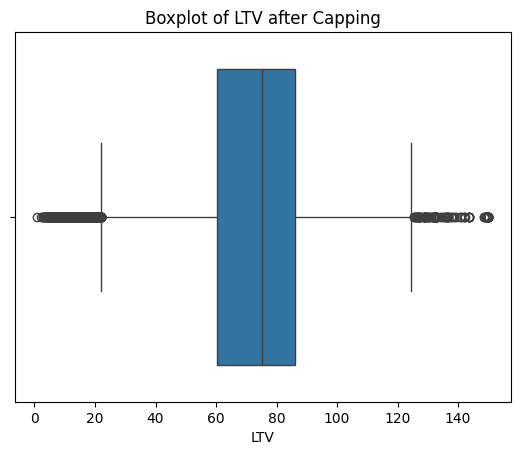

In [ ]:
# boxplot for LTV after capping
sns.boxplot(x=df["LTV"])
plt.title("Boxplot of LTV after Capping")
plt.show()

## Transformation Pipeline

In [9]:
# ------- DEFINE FEATURE LISTS -------

# Log Transform Columns
log_transform_cols = [
    'loan_amount',
    'property_value',
    'income',
    'Upfront_charges'
]

# Numerical columns for imputation and scaling
numerical_cols = [
    'rate_of_interest',
    'Interest_rate_spread',
    'term',
    'Credit_Score',
    'LTV',
    'dtir1',
    'age_numerical'
]


# Categorical columns for imputation and One-Hot Encoding
categorical_cols = [
    'loan_limit',
    'Gender',
    'approv_in_adv',
    'loan_type',
    'loan_purpose',
    'Credit_Worthiness',
    'open_credit',
    'business_or_commercial',
    'Neg_ammortization',
    'interest_only',
    'lump_sum_payment',
    'construction_type',
    'occupancy_type',
    'Secured_by',
    'total_units',
    'credit_type',
    'co-applicant_credit_type',
    'submission_of_application',
    'Region',
    'Security_Type'
]

In [10]:
# ------- LOG TRANSFROMATION -----
log_pipeline = Pipeline(
    steps= [
        ('imputer', SimpleImputer(strategy='median')),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('scalar', StandardScaler())
    ]
)

log_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('log_transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('scalar', StandardScaler())])

In [11]:
# ------ NUMERICAL PIPELINE ------
num_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scalar', StandardScaler())
    ]
)

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scalar', StandardScaler())])

In [19]:
# ------ CATEGORICAL PIPELINE ------
cat_pipeline =  Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [20]:
# ------ COMBINE ALL PIPELINES USING COLUMN TRANSFORMER ------

preprocessor = ColumnTransformer(
    transformers=[
        ('log_num', log_pipeline, log_transform_cols),
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ],
    remainder= "drop"
)

preprocessor

ColumnTransformer(transformers=[('log_num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scalar', StandardScaler())]),
                                 ['loan_amount', 'property_value', 'income',
                                  'Upfront_charges']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalar', StandardScaler())]...
                                                                sparse_output=False))]),
                                 ['loan_limit', 'Gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'Credit_Worthiness', 'open_credit',
                                  'business_or_commercial', 'Neg_ammortization',
                                  'interest_only', 'lump_sum_payment',
                                  'construction_type', 'occupancy_type',
                                  'Secured_by', 'total_units', 'credit_type',
                                  'co-applicant_credit_type',
                                  'submission_of_application', 'Region',
                                  'Security_Type'])])

In [21]:
# --------- FULL TRANSFORMATION PIPELINE---------
full_pipeline = Pipeline(
    steps = [
        ('data_cleaning', FunctionTransformer(clean_data, validate=False)),
        ('preprocessor', preprocessor)
    ]
)

full_pipeline

Pipeline(steps=[('data_cleaning',
                 FunctionTransformer(func=<function clean_data at 0x0000026A469E4E00>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'property_value', 'income'...
                                                                                 sparse_output=False))]),
                                                  ['loan_limit', 'Gender',
                                                   'approv_in_adv', 'loan_type',
                                                   'loan_purpose',
                                                   'Credit_Worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'Neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type',
                                                   'Secured_by', 'total_units',
                                                   'credit_type',
                                                   'co-applicant_credit_type',
                                                   'submission_of_application',
                                                   'Region',
                                                   'Security_Type'])]))])

## Applying Transformation on Data

In [22]:
# ------ DATA SPLIT -------

# Feature Matrice
X = df.drop(columns= "Status")

# Traget Vector
y = df["Status"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,dtir1
141245,166135,2019,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,...,2460.0,CIB,605,EXP,>74,to_inst,70.833333,south,direct,12.0
3507,28397,2019,NaN,Male,nopre,type1,p4,l1,nopc,nob/c,...,7200.0,EXP,729,CIB,45-54,not_inst,59.967672,south,direct,43.0
53688,78578,2019,cf,Female,pre,type2,p3,l1,nopc,b/c,...,2100.0,CIB,609,CIB,65-74,to_inst,85.472973,North,direct,42.0
46491,71381,2019,cf,Male,nopre,type1,p3,l1,nopc,nob/c,...,8220.0,EXP,600,CIB,45-54,not_inst,85.590278,central,direct,41.0
54671,79561,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,8940.0,CRIF,701,EXP,55-64,not_inst,58.756039,south,direct,35.0


In [23]:
# ------- TRANSFORM DATASET --------

# fit pipeline to training set
X_train_processed = full_pipeline.fit_transform(X_train)

# transform the test data
X_test_processed = full_pipeline.transform(X_test)

X_train_processed.shape


(118936, 63)

In [18]:
X_test_processed.shape

(29734, 63)